# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# Read the CSV file into a pandas DataFrame
hi1_df = pd.read_csv('hi1_20170701_20200609.csv')
hi1_df['time'] = hi1_df['time'].astype(str).str.zfill(6)
hi1_df['datetime'] = pd.to_datetime(hi1_df['date'].astype(str) + hi1_df['time'], format='%Y%m%d%H%M%S')
hi1_df = hi1_df.drop(columns=['date', 'time'])
hi1_df = hi1_df[['datetime', 'hi1_close']]

# Calculate log returns
hi1_df['log_return'] = np.log(hi1_df['hi1_close'] / hi1_df['hi1_close'].shift(1))

hi1_df.head()

# separate the data into training and testing set
train_df = hi1_df[hi1_df['datetime'] < '2019-01-01']
test_df = hi1_df[hi1_df['datetime'] >= '2019-01-01']


# Baseline

In [3]:
TRANSACTION_RATE = 0.0016

# Define the EMA trading strategy function
def ema_strategy(df, short_window=5, long_window=20, transaction_rate=TRANSACTION_RATE):

    # Create a copy of the dataframe to avoid modifying the original
    strategy_df = df.copy()
    
    # Calculate the short and long EMAs
    strategy_df['short_ema'] = strategy_df['hi1_close'].ewm(span=short_window, adjust=False).mean()
    strategy_df['long_ema'] = strategy_df['hi1_close'].ewm(span=long_window, adjust=False).mean()
    
    # Generate buy/sell signals
    # 1 = buy, -1 = sell, 0 = hold
    strategy_df['signal'] = 0
    strategy_df.loc[strategy_df['short_ema'] > strategy_df['long_ema'], 'signal'] = 1
    strategy_df.loc[strategy_df['short_ema'] < strategy_df['long_ema'], 'signal'] = -1
    
    # Calculate position changes
    strategy_df['position_change'] = strategy_df['signal'].diff()
    
    # Calculate transaction costs
    strategy_df['transaction_cost'] = 0.0
    # Apply transaction costs when position changes (buy or sell)
    strategy_df.loc[strategy_df['position_change'] != 0, 'transaction_cost'] = transaction_rate
    
    # Calculate strategy returns
    strategy_df['ema_return'] = strategy_df['signal'].shift(1) * strategy_df['log_return'] - strategy_df['transaction_cost']
    
    # Calculate cumulative returns
    strategy_df['ema_cumulative_return'] = np.exp(strategy_df['ema_return'].cumsum()) - 1
    
    return strategy_df

# Function to optimize EMA parameters
def optimize_ema_parameters(df, short_windows=range(800, 1200, 10), long_windows=range(1500, 2000, 10)):

    best_return = -float('inf')
    best_short = 0
    best_long = 0
    
    results = []
    
    from tqdm.notebook import tqdm
    for short_window in tqdm(short_windows, desc="Short Window"):
        for long_window in tqdm(long_windows, desc="Long Window", leave=False):
            if short_window >= long_window:
                continue
                
            strategy_result = ema_strategy(df, short_window, long_window)
            final_return = strategy_result['ema_cumulative_return'].iloc[-1]
            
            results.append((short_window, long_window, final_return))
            
            if final_return > best_return:
                best_return = final_return
                best_short = short_window
                best_long = long_window
    
    # plot the parameter and return
    results_df = pd.DataFrame(results, columns=['short_window', 'long_window', 'return'])
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df['short_window'], results_df['long_window'], c=results_df['return'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Return')
    plt.title('Return by Short and Long Window')
    plt.xlabel('Short Window')
    plt.ylabel('Long Window')
    

    return best_short, best_long, best_return, results

# Function to implement a momentum strategy with filtering
def momentum_strategy(df, lookback_period=10, threshold=0.02, transaction_rate=TRANSACTION_RATE):

    # Create a copy of the dataframe to avoid modifying the original
    strategy_df = df.copy()
    
    # Calculate price change over lookback period
    strategy_df['price_change'] = strategy_df['hi1_close'].pct_change(lookback_period)
    
    # Generate signals based on threshold
    strategy_df['signal'] = 0
    strategy_df.loc[strategy_df['price_change'] > threshold, 'signal'] = 1  # Buy signal
    strategy_df.loc[strategy_df['price_change'] < -threshold, 'signal'] = -1  # Sell signal
    
    # Fill NaN values with 0
    strategy_df['signal'] = strategy_df['signal'].fillna(0)
    
    # Forward fill signals to create positions (hold until signal changes)
    strategy_df['position'] = strategy_df['signal'].copy()
    # Replace 0s with previous non-zero values (maintain position until new signal)
    mask = strategy_df['position'] == 0
    strategy_df.loc[mask, 'position'] = np.nan
    # Forward fill NaN values with previous positions
    strategy_df['position'] = strategy_df['position'].ffill()
    # Fill any remaining NaNs with 0 (for the beginning of the series)
    strategy_df['position'] = strategy_df['position'].fillna(0)
    
    # Calculate position changes for transaction costs
    strategy_df['position_change'] = strategy_df['position'].diff().fillna(0)
    
    # Calculate transaction costs
    strategy_df['transaction_cost'] = 0.0
    strategy_df.loc[strategy_df['position_change'] != 0, 'transaction_cost'] = transaction_rate
    
    # Calculate strategy returns
    strategy_df['momentum_return'] = strategy_df['position'].shift(1) * strategy_df['log_return'] - strategy_df['transaction_cost']
    
    # Calculate cumulative returns
    strategy_df['momentum_cumulative_return'] = np.exp(strategy_df['momentum_return'].cumsum()) - 1
    
    return strategy_df

# Function to optimize momentum strategy parameters
def optimize_momentum_parameters(df, lookback_periods=range(2000, 2500, 10), thresholds=np.arange(0.001, 0.01, 0.0001)):
    best_return = -float('inf')
    best_lookback = 0
    best_threshold = 0
    
    results = []
    
    from tqdm.notebook import tqdm
    for lookback in tqdm(lookback_periods, desc="Lookback"):
        for threshold in tqdm(thresholds, desc="Threshold", leave=False):
            strategy_result = momentum_strategy(df, lookback, threshold)
            final_return = strategy_result['momentum_cumulative_return'].iloc[-1]
            
            results.append((lookback, threshold, final_return))
            
            if final_return > best_return:
                best_return = final_return
                best_lookback = lookback
                best_threshold = threshold
    
    # Plot the parameter and return
    results_df = pd.DataFrame(results, columns=['lookback', 'threshold', 'return'])
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df['lookback'], results_df['threshold'], c=results_df['return'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Return')
    plt.title('Return by Lookback and Threshold')
    plt.xlabel('Lookback Period')
    plt.ylabel('Threshold')
    
    return best_lookback, best_threshold, best_return, results



# # # EMA
# best_short, best_long, best_return, all_results = optimize_ema_parameters(train_df)
# print(f"Best parameters: Short EMA = {best_short}, Long EMA = {best_long}, Return = {best_return:.4f}")


# # # momentum
# best_lookback, best_threshold, best_return, all_results = optimize_momentum_parameters(train_df)
# print(f"Best parameters: Lookback = {best_lookback}, Threshold = {best_threshold}, Return = {best_return:.4f}")


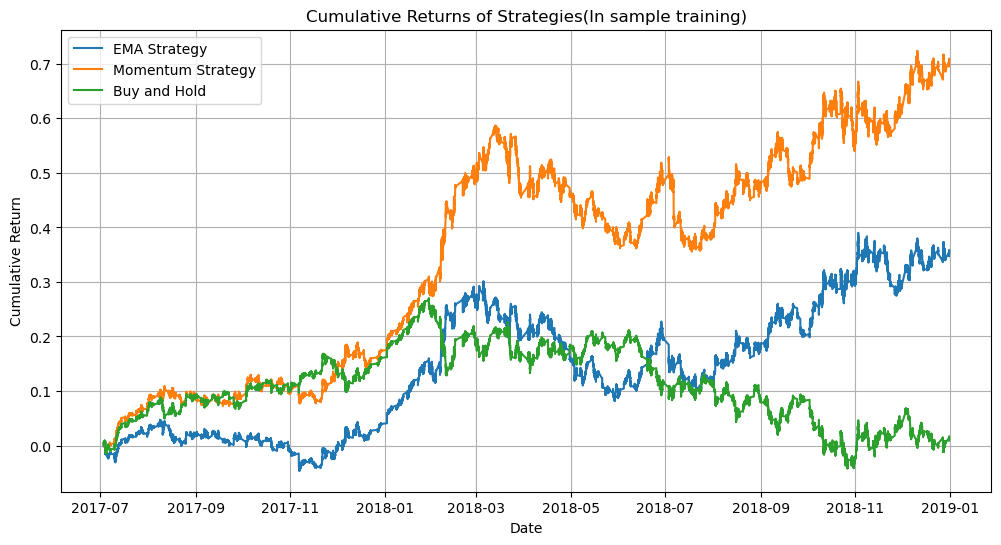

In [4]:
# Apply the EMA strategy with best parameters
train_df = ema_strategy(train_df, 1080, 1660)
train_df = momentum_strategy(train_df, 2260, 0.0061)

train_df = train_df[['datetime', 'hi1_close', 'log_return', 'ema_cumulative_return', 'momentum_cumulative_return']]
train_df.head()

# plot the cumulative return of strategies
plt.figure(figsize=(12, 6))
plt.plot(train_df['datetime'], train_df['ema_cumulative_return'], label='EMA Strategy')
plt.plot(train_df['datetime'], train_df['momentum_cumulative_return'], label='Momentum Strategy')
# Calculate buy and hold return for comparison
train_df['buy_hold_return'] = train_df['log_return'].cumsum()
plt.plot(train_df['datetime'], train_df['buy_hold_return'], label='Buy and Hold')
plt.title('Cumulative Returns of Strategies(In sample training)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


                  datetime  hi1_close  log_return  ema_cumulative_return  \
290070 2019-01-02 09:14:00    25856.0    0.000077                    NaN   
290071 2019-01-02 09:15:00    25779.0   -0.002982              -0.001599   
290072 2019-01-02 09:16:00    25792.0    0.000504              -0.002102   
290073 2019-01-02 09:17:00    25765.0   -0.001047              -0.001056   
290074 2019-01-02 09:18:00    25747.0   -0.000699              -0.000358   

        momentum_cumulative_return  
290070                         NaN  
290071                         0.0  
290072                         0.0  
290073                         0.0  
290074                         0.0  


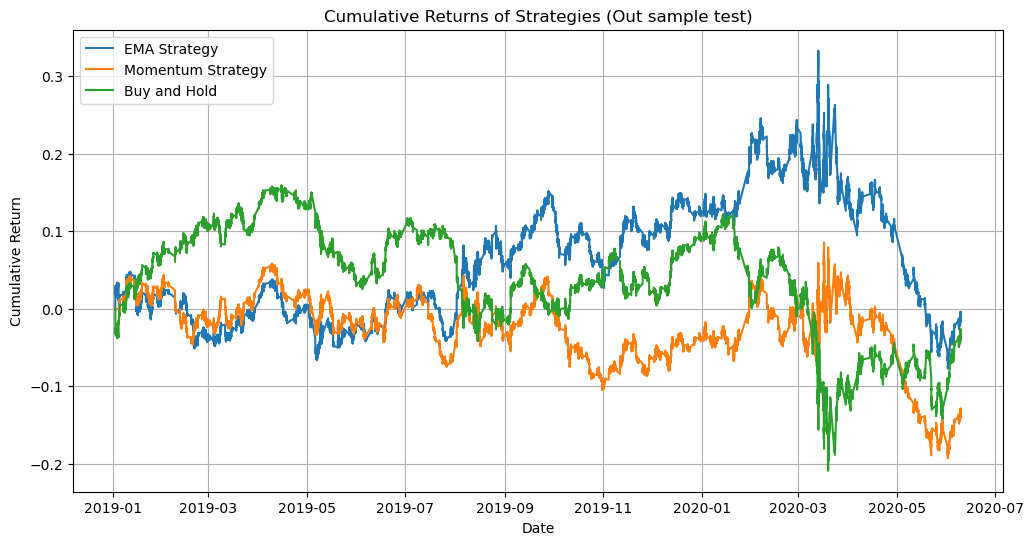

In [5]:
test_df = ema_strategy(test_df, 1050, 1700)
test_df = momentum_strategy(test_df, 2260, 0.0061)

test_df = test_df[['datetime', 'hi1_close', 'log_return', 'ema_cumulative_return', 'momentum_cumulative_return']]
print(test_df.head())

# plot the cumulative return of strategies
plt.figure(figsize=(12, 6))
plt.plot(test_df['datetime'], test_df['ema_cumulative_return'], label='EMA Strategy')
plt.plot(test_df['datetime'], test_df['momentum_cumulative_return'], label='Momentum Strategy')
# Calculate buy and hold return for comparison
test_df['buy_hold_return'] = test_df['log_return'].cumsum()
plt.plot(test_df['datetime'], test_df['buy_hold_return'], label='Buy and Hold')
plt.title('Cumulative Returns of Strategies (Out sample test)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Transformer

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [7]:
hi1_df = pd.read_csv('hi1_20170701_20200609.csv')
hi1_df['log_return'] = np.log(hi1_df['hi1_close'] / hi1_df['hi1_close'].shift(1))
hi1_df['time'] = hi1_df['time'].astype(str).str.zfill(6)
hi1_df['datetime'] = pd.to_datetime(hi1_df['date'].astype(str) + hi1_df['time'], format='%Y%m%d%H%M%S')
hi1_df = hi1_df.drop(columns=['date', 'time'])
hi1_df = hi1_df.dropna().reset_index(drop=True)
hi1_df = hi1_df[["datetime","hi1_close","log_return"]]

# separate the data into training and testing set
train_df = hi1_df[hi1_df['datetime'] < '2019-01-01']

train_df.head()

,datetime,hi1_close,log_return
0,2017-07-03 09:15:00,25547.0,0.000901
1,2017-07-03 09:16:00,25560.0,0.000509
2,2017-07-03 09:17:00,25568.0,0.000313
3,2017-07-03 09:18:00,25562.0,-0.000235
4,2017-07-03 09:19:00,25561.0,-0.000039


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch.utils.data as data
import torch.nn as nn

OUTPUT_LEN = 20

# 滑动窗口
def create_sequences(data, input_len=200, output_len=OUTPUT_LEN):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)


class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



class TransformerPredictor(nn.Module):
    def __init__(self, input_len=200, output_len=OUTPUT_LEN, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(input_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.output_proj = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, output_len)
        )

    def forward(self, x):
        # x: [batch_size, seq_len, 1]
        x = self.input_proj(x) + self.pos_encoding  # 加上位置编码
        x = self.transformer(x)  # [batch_size, seq_len, d_model]
        x = x[:, -1, :]  # 取最后一个时间步输出
        return self.output_proj(x)  # [batch_size, output_len]

In [9]:
def predict_overlapping_avg(model, X_test_tensor, scaler, output_len=OUTPUT_LEN):
    """
    对每个测试样本预测未来 output_len 步，并将重叠位置取平均。
    """
    model.eval()
    total_len = X_test_tensor.shape[0] + output_len - 1
    preds_sum = np.zeros(total_len)
    preds_count = np.zeros(total_len)

    with torch.no_grad():
        for i in tqdm(range(X_test_tensor.shape[0]), desc="Predicting"):
            input_seq = X_test_tensor[i].unsqueeze(0)  # [1, 200, 1]
            pred = model(input_seq)  # [1, 5]
            pred = pred.squeeze().cpu().numpy()

            for j in range(output_len):
                preds_sum[i + j] += pred[j]
                preds_count[i + j] += 1

    avg_pred = preds_sum / np.maximum(preds_count, 1)
    avg_pred = scaler.inverse_transform(avg_pred.reshape(-1, 1)).ravel()

    return avg_pred

def evaluate_and_plot_sliding_avg(model, X_test_tensor, y_test, scaler, datetimes, output_len=OUTPUT_LEN):
    model.eval()
    pred_avg = predict_overlapping_avg(model, X_test_tensor, scaler, output_len=output_len)

    # 真实未来20步均值（逆标准化）
    true_avg = [y.mean() for y in y_test]
    true_avg = scaler.inverse_transform(np.array(true_avg).reshape(-1, 1)).ravel()

    # 对齐的时间戳
    aligned_times = datetimes[:len(true_avg)]

    plt.figure(figsize=(15, 5))
    plt.plot(aligned_times, true_avg, label='True Avg of Next 5min', color='black')
    plt.plot(aligned_times, pred_avg[:len(true_avg)], label='Predicted Avg (Overlapping)', color='red')
    plt.title('Transformer Prediction (Overlapping Average) vs Ground Truth')
    plt.xlabel('Time')
    plt.ylabel('hi1_close Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Create a DataFrame with datetime, true price, and predicted price
    result_df = pd.DataFrame({
        'datetime': aligned_times,
        'true_price': true_avg,
        'predicted_price': pred_avg[:len(true_avg)]
    })
    
    # Display the first few rows of the DataFrame
    print("Result DataFrame:")
    print(result_df.head())
    
    return result_df

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/4529 [00:00<?, ?it/s]

Epoch 1, Loss: 18.3221


Predicting:   0%|          | 0/291810 [00:00<?, ?it/s]

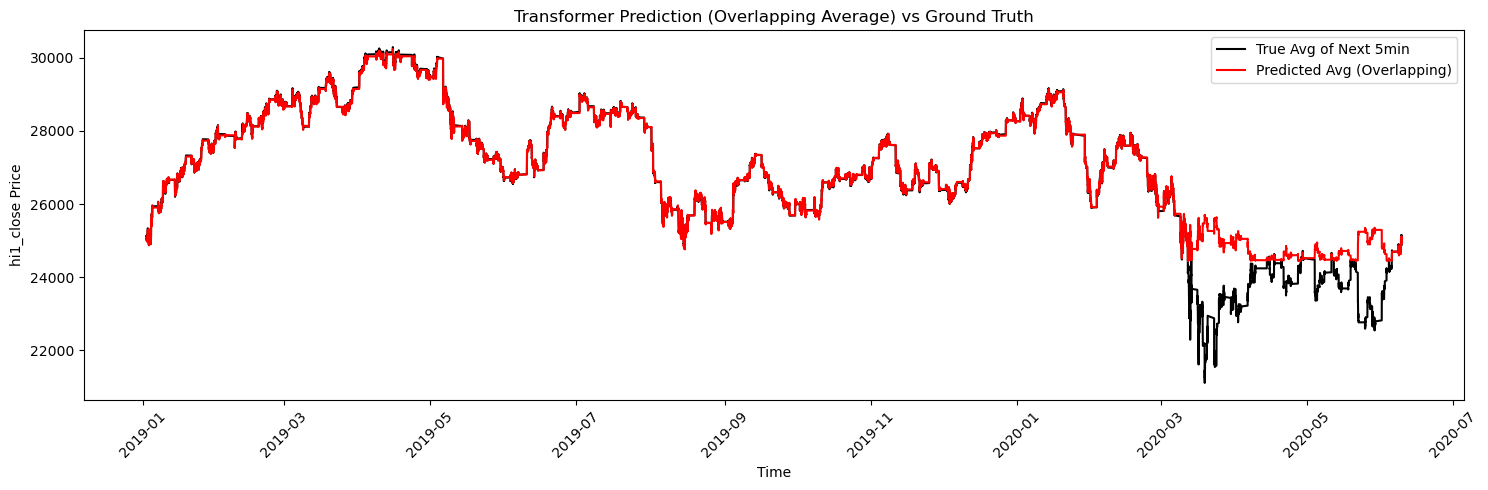

Result DataFrame:
             datetime  true_price  predicted_price
0 2019-01-02 13:51:00    25124.80     25120.656811
1 2019-01-02 13:52:00    25123.30     25117.374197
2 2019-01-02 13:53:00    25122.05     25112.953981
3 2019-01-02 13:54:00    25120.20     25110.922467
4 2019-01-02 13:55:00    25118.10     25106.009734


In [10]:
device = "mps"

prices = train_df['hi1_close'].values.reshape(-1, 1)
scaler = StandardScaler()
prices_scaled = scaler.fit_transform(prices)
X_train, y_train = create_sequences(prices_scaled)
train_dataset = data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32).squeeze(-1))
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# 使用 test_df 构建测试数据
test_prices = test_df['hi1_close'].values.reshape(-1, 1)
test_scaled = scaler.transform(test_prices)
X_test, y_test = create_sequences(test_scaled)
test_dataset = StockDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_datetimes = test_df['datetime'].values[200 + OUTPUT_LEN - 1:]  # 由于 create_sequences 的滑动窗口
test_dataset = StockDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


model = TransformerPredictor().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


for epoch in tqdm(range(1), desc="Training"):
    model.train()
    total_loss = 0
    for batch_x, batch_y in tqdm(train_loader, desc="Batch"):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        output = model(batch_x)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    # 预测绘图（传入所有需要的参数）
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    
    df_predicted = evaluate_and_plot_sliding_avg(
        model=model,
        X_test_tensor=X_test_tensor,
        y_test=y_test,
        scaler=scaler,
        datetimes=test_df['datetime'].values[200 + OUTPUT_LEN - 1:]  # 需要对齐长度
    )



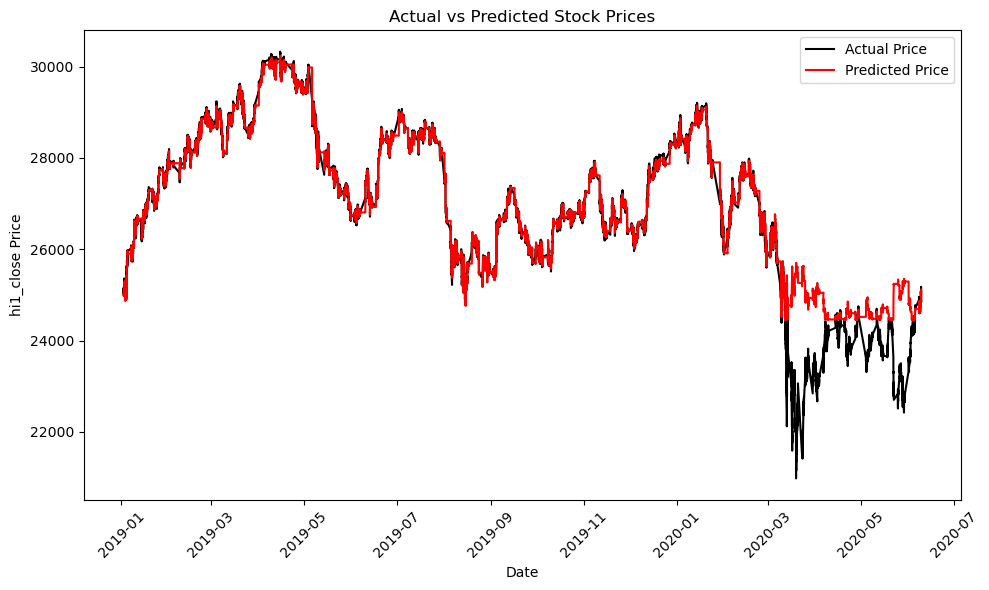

In [11]:
# 显式复制，避免警告
test_df = test_df.copy()
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

df_predicted = df_predicted.copy()
df_predicted['datetime'] = pd.to_datetime(df_predicted['datetime'])

# 合并 predicted_price 到 test_df
test_df = test_df.merge(df_predicted[['datetime', 'predicted_price']], on='datetime', how='left')

# Remove rows with NaN values
test_df = test_df.dropna(subset=['predicted_price'])

# plot 
plt.figure(figsize=(10, 6))
plt.plot(test_df['datetime'], test_df['hi1_close'], label='Actual Price', color='black')
plt.plot(test_df['datetime'], test_df['predicted_price'], label='Predicted Price', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('hi1_close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
print(test_df.head())
TRANSACTION_RATE=0.0016

               datetime  hi1_close  log_return  ema_cumulative_return  \
219 2019-01-02 13:51:00    25124.0    0.000119               0.024430   
220 2019-01-02 13:52:00    25107.0   -0.000677               0.025124   
221 2019-01-02 13:53:00    25115.0    0.000319               0.024797   
222 2019-01-02 13:54:00    25102.0   -0.000518               0.025328   
223 2019-01-02 13:55:00    25084.0   -0.000717               0.026064   

     momentum_cumulative_return  buy_hold_return  predicted_price  
219                         0.0        -0.028642     25120.656811  
220                         0.0        -0.029319     25117.374197  
221                         0.0        -0.029000     25112.953981  
222                         0.0        -0.029518     25110.922467  
223                         0.0        -0.030235     25106.009734  


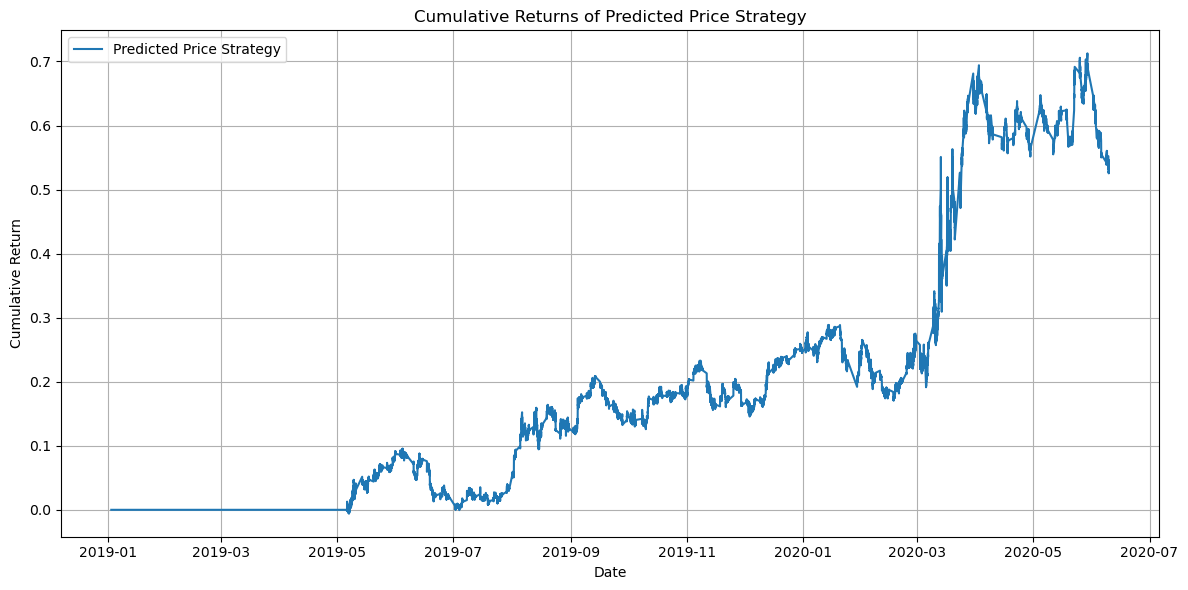

In [18]:
# Function to implement a strategy based on predicted prices
def predicted_price_strategy(df, lookback_period=20, transaction_rate=TRANSACTION_RATE, threshold_rate=8.8):
    # Create a copy of the dataframe to avoid modifying the original
    strategy_df = df.copy()
    
    # Calculate price change over lookback period for predicted prices
    strategy_df['predicted_price_change'] = strategy_df['predicted_price'].pct_change(lookback_period)
    
    # Define threshold as 2 times the transaction rate
    threshold = threshold_rate * transaction_rate
    
    # Generate signals based on threshold
    strategy_df['signal'] = 0
    strategy_df.loc[strategy_df['predicted_price_change'] > threshold, 'signal'] = 1  # Buy signal
    strategy_df.loc[strategy_df['predicted_price_change'] < -threshold, 'signal'] = -1  # Sell signal
    
    # Fill NaN values with 0
    strategy_df['signal'] = strategy_df['signal'].fillna(0)
    
    # Forward fill signals to create positions (hold until signal changes)
    strategy_df['position'] = strategy_df['signal'].copy()
    # Replace 0s with previous non-zero values (maintain position until new signal)
    mask = strategy_df['position'] == 0
    strategy_df.loc[mask, 'position'] = np.nan
    # Forward fill NaN values with previous positions
    strategy_df['position'] = strategy_df['position'].ffill()
    # Fill any remaining NaNs with 0 (for the beginning of the series)
    strategy_df['position'] = strategy_df['position'].fillna(0)
    
    # Calculate position changes for transaction costs
    strategy_df['position_change'] = strategy_df['position'].diff().fillna(0)
    
    # Calculate transaction costs
    strategy_df['transaction_cost'] = 0.0
    strategy_df.loc[strategy_df['position_change'] != 0, 'transaction_cost'] = transaction_rate
    
    # Calculate strategy returns
    strategy_df['predicted_strategy_return'] = strategy_df['position'].shift(1) * strategy_df['log_return'] - strategy_df['transaction_cost']
    
    # Calculate cumulative returns
    strategy_df['predicted_cumulative_return'] = np.exp(strategy_df['predicted_strategy_return'].cumsum()) - 1
    
    return strategy_df

# Apply the strategy to the test data
predicted_strategy_df = predicted_price_strategy(test_df, lookback_period=20, transaction_rate=TRANSACTION_RATE)

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(predicted_strategy_df['datetime'], predicted_strategy_df['predicted_cumulative_return'], label='Predicted Price Strategy')
plt.title('Cumulative Returns of Predicted Price Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# # Plot the curve of cumulative return of different threshold_rate
# threshold_rates = np.arange(1, 15, 0.5)  # Reduced step size for better visualization
# final_returns = []

# plt.figure(figsize=(12, 6))
# for threshold_rate in threshold_rates:
#     predicted_strategy_df = predicted_price_strategy(test_df, lookback_period=20, transaction_rate=TRANSACTION_RATE, threshold_rate=threshold_rate)
#     # Get the final cumulative return
#     final_return = predicted_strategy_df['predicted_cumulative_return'].iloc[-1]
#     final_returns.append(final_return)

# # Plot the relationship between threshold rate and final cumulative return
# plt.plot(threshold_rates, final_returns, marker='o')
# plt.title('Effect of Threshold Rate on Strategy Performance')
# plt.xlabel('Threshold Rate')
# plt.ylabel('Final Cumulative Return')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # plot the curve of cumulative return of different lookback_period
# lookback_periods = np.arange(1, 100, 1)
# final_returns = []

# plt.figure(figsize=(12, 6))
# for lookback_period in lookback_periods:
#     predicted_strategy_df = predicted_price_strategy(test_df, lookback_period=lookback_period, transaction_rate=TRANSACTION_RATE, threshold_rate=1.1)
#     final_return = predicted_strategy_df['predicted_cumulative_return'].iloc[-1]
#     final_returns.append(final_return)
    
    

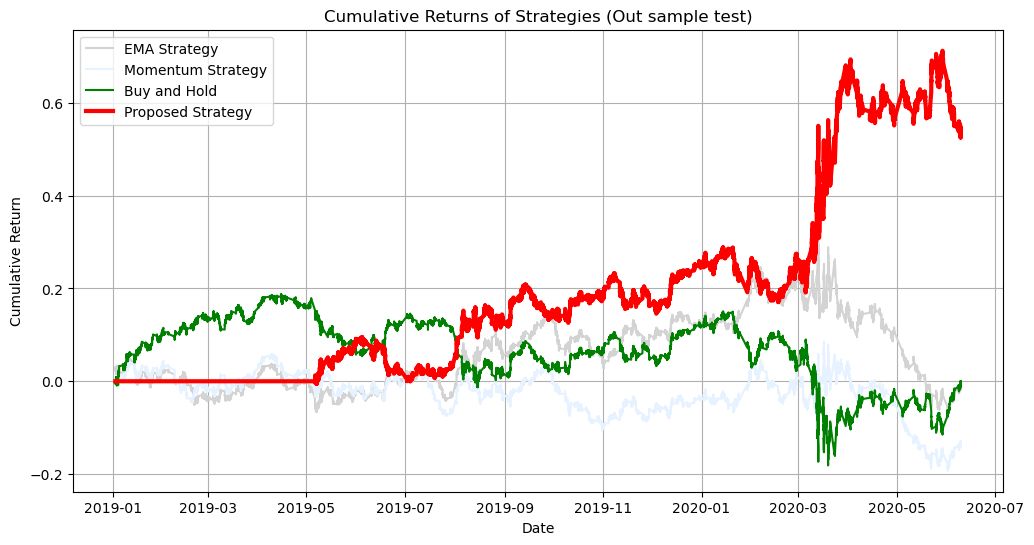

In [19]:
# Drop rows with NaN values
predicted_strategy_df = predicted_strategy_df.dropna()
predicted_strategy_df.head()

predicted_strategy_df = predicted_strategy_df[['datetime', 'hi1_close', 'log_return', 'ema_cumulative_return', 'momentum_cumulative_return', 'predicted_cumulative_return']]
predicted_strategy_df.head()

# plot the cumulative return of strategies
plt.figure(figsize=(12, 6))
# Use low contrast colors for other strategies
plt.plot(predicted_strategy_df['datetime'], predicted_strategy_df['ema_cumulative_return'], label='EMA Strategy', color='lightgray')
plt.plot(predicted_strategy_df['datetime'], predicted_strategy_df['momentum_cumulative_return'], label='Momentum Strategy', color='#e6f2ff')
# Calculate buy and hold return for comparison with low contrast
predicted_strategy_df['buy_hold_return'] = predicted_strategy_df['log_return'].cumsum()
plt.plot(predicted_strategy_df['datetime'], predicted_strategy_df['buy_hold_return'], label='Buy and Hold', color='green')
# Highlight the proposed strategy with a bold color
plt.plot(predicted_strategy_df['datetime'], predicted_strategy_df['predicted_cumulative_return'], label='Proposed Strategy', color='red', linewidth=3)
plt.title('Cumulative Returns of Strategies (Out sample test)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

Risk Management Metrics Comparison:
                   Total Return  Annualized Return  Volatility  Sharpe Ratio  \
Strategy                                                                       
EMA Strategy            -0.0409            -0.0000      0.0096       -0.0036   
Momentum Strategy       -0.1395            -0.0001      0.0084       -0.0150   
Proposed Strategy        0.5448             0.0004      0.0113        0.0323   
Buy and Hold            -0.0117            -0.0000      0.0088       -0.0011   

                   Max Drawdown  Sortino Ratio  Calmar Ratio  Win Rate  
Strategy                                                                
EMA Strategy            -0.3508        -0.0040       -0.0001    0.4461  
Momentum Strategy       -0.2531        -0.0164       -0.0005    0.4421  
Proposed Strategy       -0.2170         0.0323        0.0017    0.3496  
Buy and Hold            -0.3292        -0.0012       -0.0000    0.4530  


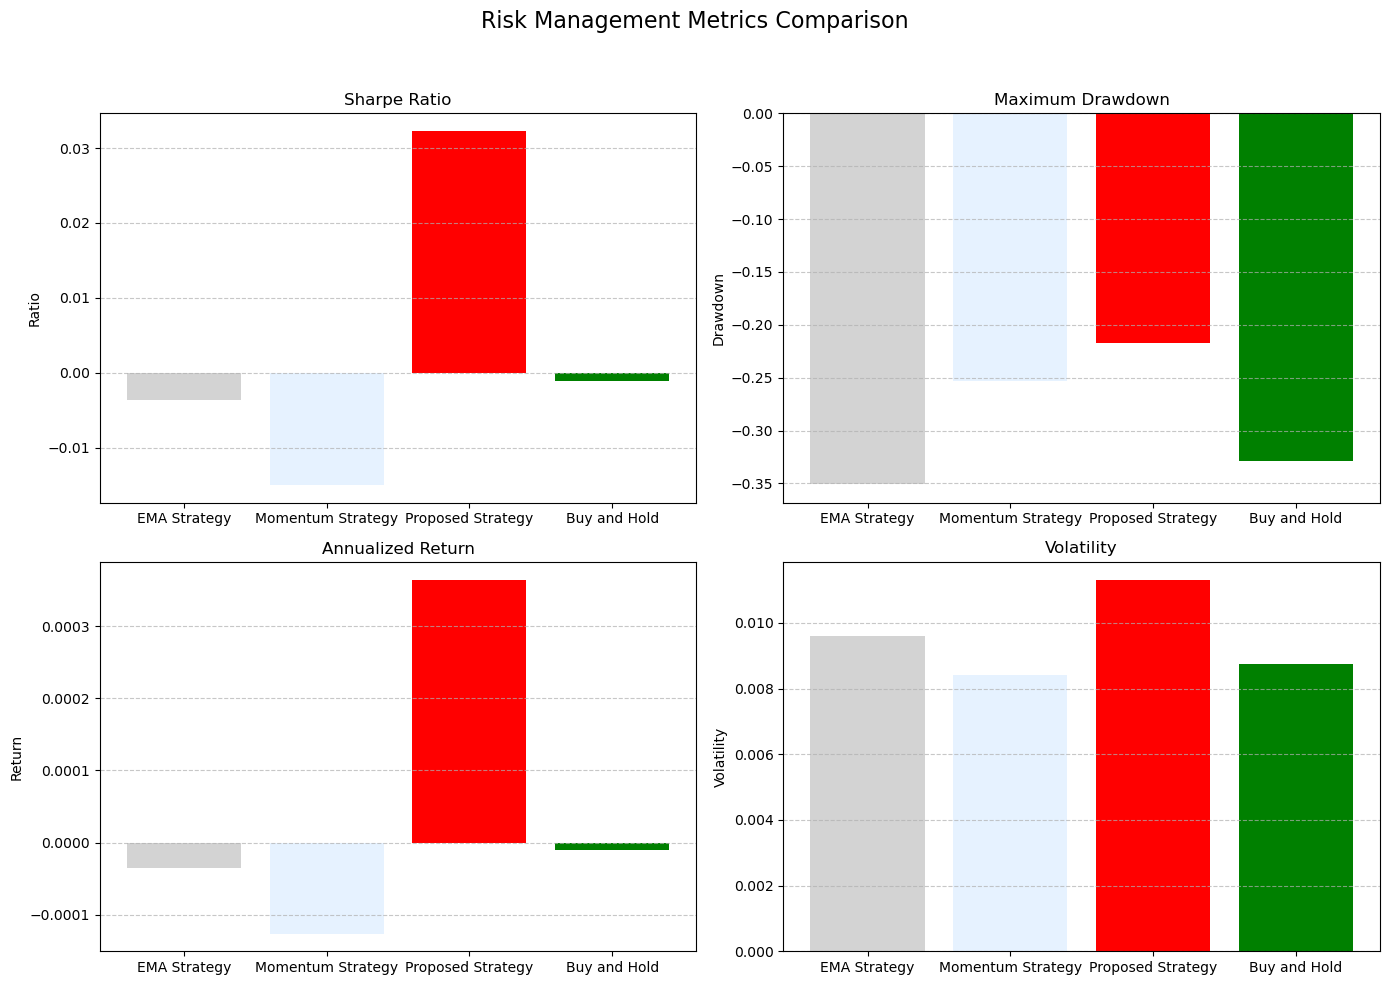

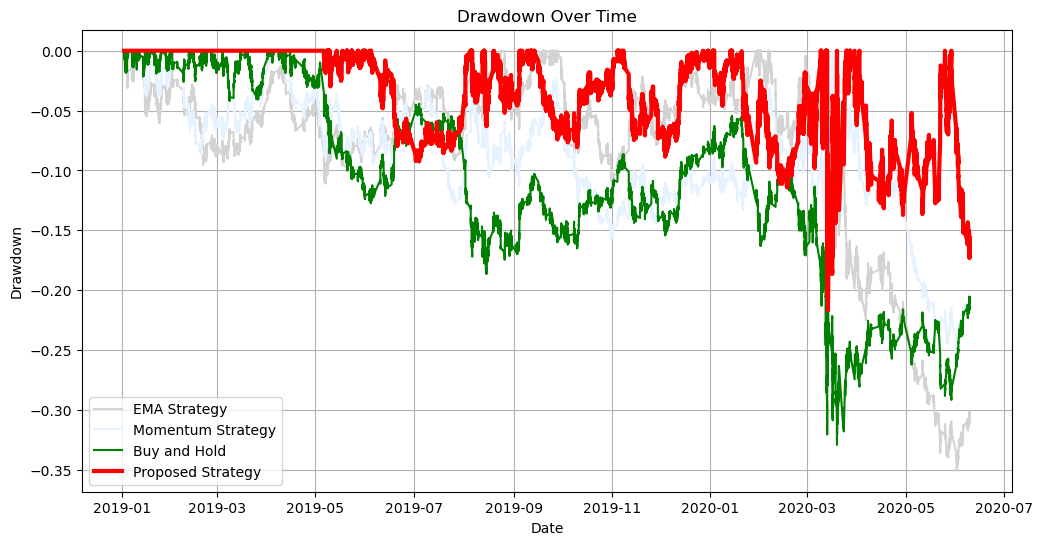

In [20]:
predicted_strategy_df.head()

# %% cell 19 code

# Calculate risk management metrics for all strategies
import pandas as pd
import numpy as np
from scipy import stats

# Extract returns for each strategy
ema_returns = predicted_strategy_df['ema_cumulative_return'].diff().fillna(0)
momentum_returns = predicted_strategy_df['momentum_cumulative_return'].diff().fillna(0)
predicted_returns = predicted_strategy_df['predicted_cumulative_return'].diff().fillna(0)
buy_hold_returns = predicted_strategy_df['buy_hold_return'].diff().fillna(0)

# Function to calculate risk metrics
def calculate_risk_metrics(returns, strategy_name):
    # Annualization factor (assuming daily data)
    trading_days = 252
    
    # Total return
    total_return = returns.sum()
    
    # Annualized return
    annualized_return = (1 + total_return) ** (trading_days / len(returns)) - 1
    
    # Volatility (annualized standard deviation)
    volatility = returns.std() * np.sqrt(trading_days)
    
    # Sharpe ratio (assuming risk-free rate = 0)
    sharpe_ratio = annualized_return / volatility if volatility != 0 else 0
    
    # Maximum drawdown
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative / running_max) - 1
    max_drawdown = drawdown.min()
    
    # Sortino ratio (downside deviation)
    negative_returns = returns[returns < 0]
    downside_deviation = negative_returns.std() * np.sqrt(trading_days)
    sortino_ratio = annualized_return / downside_deviation if downside_deviation != 0 else 0
    
    # Calmar ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Win rate
    win_rate = len(returns[returns > 0]) / len(returns)
    
    return {
        'Strategy': strategy_name,
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio,
        'Win Rate': win_rate
    }

# Calculate metrics for each strategy
ema_metrics = calculate_risk_metrics(ema_returns, 'EMA Strategy')
momentum_metrics = calculate_risk_metrics(momentum_returns, 'Momentum Strategy')
predicted_metrics = calculate_risk_metrics(predicted_returns, 'Proposed Strategy')
buy_hold_metrics = calculate_risk_metrics(buy_hold_returns, 'Buy and Hold')

# Combine results into a DataFrame
risk_metrics_df = pd.DataFrame([
    ema_metrics,
    momentum_metrics,
    predicted_metrics,
    buy_hold_metrics
])

# Display the risk metrics
print("Risk Management Metrics Comparison:")
print(risk_metrics_df.set_index('Strategy').round(4))

# %% cell 20 code

# Visualize key risk metrics
import matplotlib.pyplot as plt

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Risk Management Metrics Comparison', fontsize=16)

# Strategies
strategies = risk_metrics_df['Strategy']

# Plot Sharpe Ratio
axes[0, 0].bar(strategies, risk_metrics_df['Sharpe Ratio'], color=['lightgray', '#e6f2ff', 'red', 'green'])
axes[0, 0].set_title('Sharpe Ratio')
axes[0, 0].set_ylabel('Ratio')
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Max Drawdown
axes[0, 1].bar(strategies, risk_metrics_df['Max Drawdown'], color=['lightgray', '#e6f2ff', 'red', 'green'])
axes[0, 1].set_title('Maximum Drawdown')
axes[0, 1].set_ylabel('Drawdown')
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Annualized Return
axes[1, 0].bar(strategies, risk_metrics_df['Annualized Return'], color=['lightgray', '#e6f2ff', 'red', 'green'])
axes[1, 0].set_title('Annualized Return')
axes[1, 0].set_ylabel('Return')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Volatility
axes[1, 1].bar(strategies, risk_metrics_df['Volatility'], color=['lightgray', '#e6f2ff', 'red', 'green'])
axes[1, 1].set_title('Volatility')
axes[1, 1].set_ylabel('Volatility')
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# %% cell 21 code

# Calculate drawdown over time for each strategy
def calculate_drawdown_series(returns):
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative / running_max) - 1
    return drawdown

# Calculate drawdown for each strategy
ema_drawdown = calculate_drawdown_series(ema_returns)
momentum_drawdown = calculate_drawdown_series(momentum_returns)
predicted_drawdown = calculate_drawdown_series(predicted_returns)
buy_hold_drawdown = calculate_drawdown_series(buy_hold_returns)

# Plot drawdown over time
plt.figure(figsize=(12, 6))
plt.plot(predicted_strategy_df['datetime'], ema_drawdown, label='EMA Strategy', color='lightgray')
plt.plot(predicted_strategy_df['datetime'], momentum_drawdown, label='Momentum Strategy', color='#e6f2ff')
plt.plot(predicted_strategy_df['datetime'], buy_hold_drawdown, label='Buy and Hold', color='green')
plt.plot(predicted_strategy_df['datetime'], predicted_drawdown, label='Proposed Strategy', color='red', linewidth=3)
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()
